In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as ani
from matplotlib.colors import Normalize
from IPython.display import HTML
import copy

In [2]:
## SIMULATION PARAMETERS

# Frame width (x axis, dx=1) in 100um
Lx = 100
# Frame width (y axis, dy=1) in 100um
Ly = 100
# Time Resolution in seconds
dt = 1
# Time steps
T = 20000

print("Simulation time = ", T*dt, 'sec')

Simulation time =  20000 sec


In [3]:
## STATE VARIABLES

# C1 = density of cooperator (antibiotic resistant)
# C2 = density of cheater (antibiotic sensitive)
# S = concentration of nutrient (glucose)
# A = concentration of antibiotic

## MODEL PARAMETERS

r1 = 1.2/3600         # max growth rate of cooperator (in 1/sec)
r2 = 1.32/3600        # max growth rate of cheater (in 1/sec)
Ks = 4*10**-6         # rate of nutrient consumption by Monod kinetics (in g/mL)
Km = 18*10**-6        # Michaelis-Menton rate constant for antibiotic inactivation by cooperator (in g/mL)
Vmax = 4*10**3/3600   # Maximum antibiotic inactivation rate (in mL/(g.sec))
IC50 = 10**-6         # antibiotic concentration at which cheater growth rate is halved (in g/mL)
Y = 0.5               # biomass yield (in g biomass/g glucose)
S0 = 0.004            # glucose concentration in feed medium (in g/mL)
A0 = 0.004            # antiobiotic concentration in feed medium (in g/mL)
DC = 0.01              # diffusion coefficient of biomass (in 10^4 um^2/sec)
DS = 0.06             # diffusion coefficient of glucose (in 10^4 um^2/sec)
DA = 0.04             # diffusion coefficient of antibiotic (in 10^4 um^2/sec)
f1 = 0.1              # initial density of loading sites for cooperators (fraction of grid points)
f2 = 0.1              # initial density of loading sites for cheaters (fraction of grid points)
C0 = 0.01             # inital biomass concentration at loading sites

""" Note: Mesh Fourier number F = D*dt/dx^2 = D """
""" F < 0.5 for stability in diffusion model with Forward Euler method """

' F < 0.5 for stability in diffusion model with Forward Euler method '

In [4]:
# Initialize

def initialize_1D():
    C1 = np.zeros((1,Lx+1))
    C2 = np.zeros((1,Lx+1))
    S = np.ones((1,Lx+1))*S0
    A = np.ones((1,Lx+1))*A0
    
    # sample random points to load bacteria
    n1 = int(np.ceil(f1*(Lx-1)))
    n2 = int(np.ceil(f2*(Lx-1)))
    ind1 = np.random.randint(low=1, high=Lx-1, size=n1)
    ind2 = np.random.randint(low=1, high=Lx-1, size=n2)

    for i in ind1:
        C1[0,i] = C0 
    
    for i in ind2:
        C2[0,i] = C0 
        
    return(C1, C2, S, A)

def initialize_2D():
    C1 = np.zeros((Ly+1,Lx+1))
    C2 = np.zeros((Ly+1,Lx+1))
    S = np.ones((Ly+1,Lx+1))*S0
    A = np.ones((Ly+1,Lx+1))*A0
    
    # sample random points to load bacteria
    n1 = int(np.ceil(f1*(Lx-1)*(Ly-1)))
    n2 = int(np.ceil(f2*(Lx-1)*(Ly-1)))
    ind1 = np.random.randint(low=1, high=int((Lx-1)*(Ly-1)), size=n1)
    ind2 = np.random.randint(low=1, high=int((Lx-1)*(Ly-1)), size=n2)

    for i in ind1:
        x = int(np.ceil(i/(Lx-1)))
        y = i%(Lx-1)+1
        C1[x,y] = C0 
    
    for i in ind2:
        x = int(np.ceil(i/(Lx-1)))
        y = i%(Lx-1)+1
        C2[x,y] = C0 
        
    return(C1, C2, S, A)

In [5]:
def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

In [10]:
# Forward Euler method for updating concentrations at each time step

def update_1d(C1, C2, S, A):
    mu_1 = r1*S/(Ks+S)
    mu_2 = r2*S/((Ks+S)*(1+A/IC50))
    C1_diff = mu_1*C1 + DC*discrete_laplacian((C1+C2)/(1-C1-C2))
    C2_diff = mu_2*C2 + DC*discrete_laplacian((C1+C2)/(1-C1-C2))
    S_diff = -(1/Y)*(mu_1*C1 + mu_2*C2) + DS*discrete_laplacian(S)
    A_diff = -Vmax*np.multiply(A,C1)/(Km+A) + DA*discrete_laplacian(A)
    
    C1+= dt*C1_diff
    C1[C1<0]=0
    C2+= dt*C2_diff
    C2[C2<0]=0
    S+= dt*S_diff
    S[S<0]=0
    A+= dt*A_diff
    A[A<0]=0
    
    #Boundary conditions on left and right
    C1[:,0], C2[:,0], S[:,0], A[:,0] = 0, 0, S0, A0
    C1[:,-1], C2[:,-1], S[:,-1], A[:,-1] = 0, 0, 0, 0
    
    '''disable/enable the line below to make the right boundary open/reflecting'''
    C1[:,-1], C2[:,-1], S[:,-1], A[:,-1] = C1[:,-2], C2[:,-2], S[:,-2], A[:,-2]
    
    return(C1, C2, S, A)

def update_2d(C1, C2, S, A):
    mu_1 = r1*S/(Ks+S)
    mu_2 = r2*S/((Ks+S)*(1+A/IC50))
    C1_diff = mu_1*C1 + DC*discrete_laplacian((C1+C2)/(1-C1-C2))
    C2_diff = mu_2*C2 + DC*discrete_laplacian((C1+C2)/(1-C1-C2))
    S_diff = -(1/Y)*(mu_1*C1 + mu_2*C2) + DS*discrete_laplacian(S)
    A_diff = -Vmax*np.multiply(A,C1)/(Km+A) + DA*discrete_laplacian(A)
    
    C1+= dt*C1_diff
    C1[C1<0]=0
    C2+= dt*C2_diff
    C2[C2<0]=0
    S+= dt*S_diff
    S[S<0]=0
    A+= dt*A_diff
    A[A<0]=0
    
    #Boundary conditions on left and right (contact with external media)
    C1[:,0], C2[:,0], S[:,0], A[:,0] = np.zeros(Ly+1), np.zeros(Ly+1), np.ones(Ly+1)*S0, np.ones(Ly+1)*A0
    C1[:,-1], C2[:,-1], S[:,-1], A[:,-1] = np.zeros(Ly+1), np.zeros(Ly+1), np.zeros(Ly+1), np.zeros(Ly+1)
    
    #Boundary conditions on top and bottom (reflecting)
    C1[0,:], C2[0,:], S[0,:], A[0,:] = C1[1,:], C2[1,:], S[1,:], A[1,:]
    C1[-1,:], C2[-1,:], S[-1,:], A[-1,:] = C1[-2,:], C2[-2,:], S[-2,:], A[-2,:]
    
    '''disable/enable the line below to make the right boundary open/reflecting'''
    C1[:,-1], C2[:,-1], S[:,-1], A[:,-1] = C1[:,-2], C2[:,-2], S[:,-2], A[:,-2]
    
    return(C1, C2, S, A)

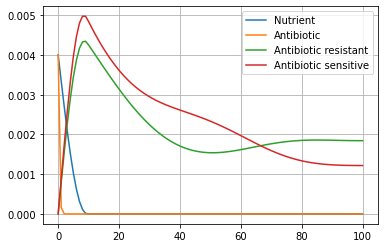

In [36]:
# Run simulation in 1D to get final distribution

C1, C2, S, A = initialize_1D()

for tt in range(T):
    C1, C2, S, A = update_1d(C1, C2, S, A)

plt.plot(S[0], label='Nutrient')
plt.plot(A[0], label='Antibiotic')
plt.plot(C1[0], label='Antibiotic resistant')
plt.plot(C2[0], label='Antibiotic sensitive')
plt.legend()
plt.grid()

end of simultaion


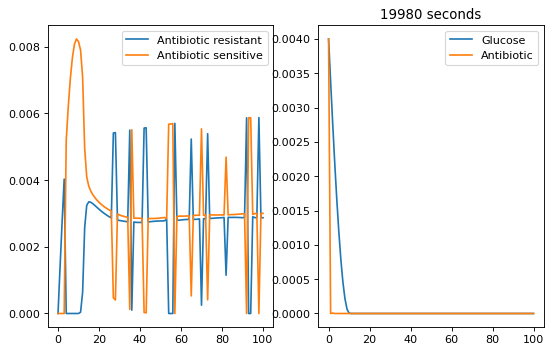

In [7]:
# Aninmation 1D to observe transient dynamics

update_every = 15
C1_time = []
C2_time = []
S_time = []
A_time = []
C1, C2, S, A = initialize_1D()
    
for tt in range(T):
    if tt%update_every == 0:
        C1_time.append(C1[0].copy())
        C2_time.append(C2[0].copy())
        S_time.append(S[0].copy())
        A_time.append(A[0].copy())
    C1, C2, S, A = update_1d(C1, C2, S, A)

print("end of simultaion")

def buildmeplot_1d(i=int):
    iv = min(i, len(C1_time) - 1)
    plt.clf()
    
    plt.subplot(121)
    plt.plot(C1_time[iv], label='Antibiotic resistant')
    plt.plot(C2_time[iv], label='Antibiotic sensitive')
    plt.legend(loc='upper right')
    
    plt.subplot(122)
    plt.plot(S_time[iv], label='Glucose')
    plt.plot(A_time[iv], label='Antibiotic')
    plt.title('{} seconds'.format(iv*update_every))
    plt.legend(loc='upper right')
    
fig = plt.figure(figsize=(8, 5), dpi=80)
animator = ani.FuncAnimation(fig, buildmeplot_1d, interval=30, frames=int(np.floor(T/update_every)))
HTML(animator.to_html5_video())

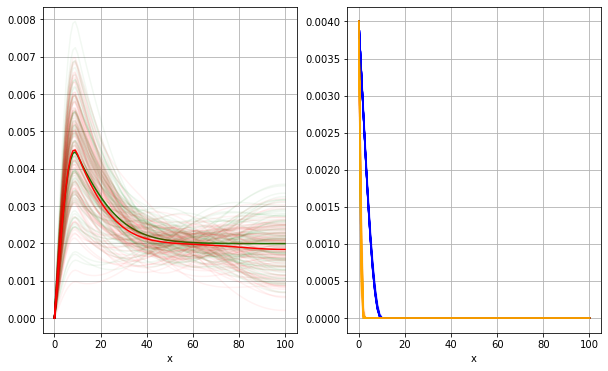

In [20]:
# Run multiple simulations and plot final distributions along with mean over all replicates

it = 100 # number of replicates

C1_dat = []
C2_dat = []
S_dat = []
A_dat = []

for i in range(it):
    C1, C2, S, A = initialize_1D()
    
    for tt in range(T):
        C1, C2, S, A = update_1d(C1, C2, S, A)
    C1_dat.append(C1[0])
    C2_dat.append(C2[0])
    S_dat.append(S[0])
    A_dat.append(A[0])

fig, a = plt.subplots(1,2, figsize=(10, 6))
a[0].plot(np.transpose(C1_dat), color='g', alpha=0.05, label='Antibiotic resistant')
a[0].plot(np.mean(np.transpose(C1_dat),axis=1), color='g', alpha=1, label='Antibiotic resistant')
a[0].plot(np.transpose(C2_dat), color='r', alpha=0.05, label='Antibiotic sensitive')
a[0].plot(np.mean(np.transpose(C2_dat),axis=1), color='r', alpha=1, label='Antibiotic sensitive')
a[0].set_xlabel('x')
a[0].grid()
a[1].plot(np.transpose(S_dat), color='b', alpha=0.1, label='Glucose')
a[1].plot(np.transpose(A_dat), color='orange', alpha=0.1, label='Antibiotic')
a[1].set_xlabel('x')
a[1].grid()

In [11]:
# 2D simulation

update_every = 15 # number of time steps after which data is stored
C1_time = []
C2_time = []
S_time = []
A_time = []
C1, C2, S, A = initialize_2D()

for tt in range(T):
    if tt%update_every == 0:
        C1_time.append(C1.copy())
        C2_time.append(C2.copy())
        S_time.append(S.copy())
        A_time.append(A.copy())
    C1, C2, S, A = update_2d(C1, C2, S, A)

print("end of simultaion")

end of simultaion


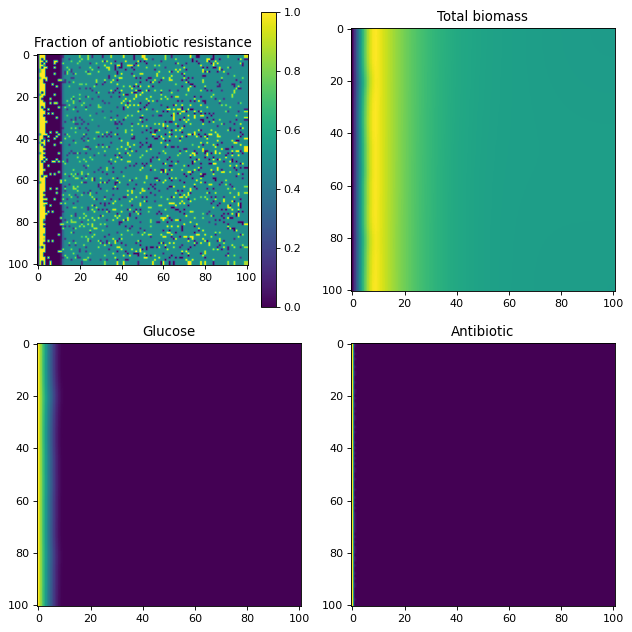

In [12]:
# Animation 2D using data from the above cell to observe transient dynamics

def buildmeplot_2d(i=int):
    iv = min(i, len(C1_time) - 1)
    plt.clf()
    
    biomass = C1_time[iv] + C2_time[iv]
    plt.subplot(221)
    plt.imshow(np.divide(C1_time[iv], biomass, out=np.zeros_like(C1_time[iv]), where=biomass!=0), vmin=0, vmax=1)
    plt.title('Fraction of antiobiotic resistance')
    plt.colorbar()
    
    plt.subplot(222)
    plt.imshow(biomass)
    plt.title('Total biomass')
    
    plt.subplot(223)
    plt.imshow(S_time[iv])
    plt.title('Glucose')
    
    plt.subplot(224)
    plt.imshow(A_time[iv])
    plt.title('Antibiotic')
    
    plt.tight_layout()
    
fig = plt.figure(figsize=(8, 8), dpi=80)
animator = ani.FuncAnimation(fig, buildmeplot_2d, interval=100, frames=int(np.floor(T/update_every)))
HTML(animator.to_html5_video())